In [1]:
import os
import pysam
import numpy as np
import pandas as pd
from tqdm import tqdm

from genome_helpers import (
    compute_af,
    get_genome_metadata
)

In [ ]:
data = get_genome_metadata()

# data = pd.read_excel("./data/genomes/metadata_whole_genome.xlsx", engine='openpyxl')
# data = data.drop(["Generation", "rep"], axis=1)
# data.loc[data.query('`samples.1` == "RMF27"').index, "samples.1"] = "0.0_-"
# sample_details = pd.DataFrame(data['samples.1'].apply(lambda x: x.split("_")[0].split(".") + [x.split("_")[1]]).to_list(), columns=["generation", "rep", "treatment"])
# data = pd.concat([data, sample_details], axis=1 )
# data.head()

: 

In [4]:
VCF_DIR = "./results/vcf/"
VCF_DIR = "data/genomes/alignments_paired_end_new/"
files = os.listdir(VCF_DIR)

In [5]:
data['BGI_ID'] = data['BGI_ID'].astype(str)

In [ ]:
variant_dict = {}
variant_freq_dict = {}

for file in files:
    
    bgi_id = file.replace(".vcf.gz", "")

    sample_info = data.loc[data.BGI_ID == bgi_id, ["generation", "rep", "treatment"]]    
    if len(sample_info) == 1:
        sample_info = sample_info.iloc[0].to_list()
        sample_info = tuple(sample_info)
    else:
        continue
        
    try:
        vcf_file = pysam.VariantFile(f"{VCF_DIR}/{file}")
    except:
        print("")
        continue
        
    variant_positions = [(record.chrom, record.pos) for record in vcf_file.fetch()]
    variant_freq = {(record.chrom, record.pos): compute_af(record) for record in vcf_file.fetch()}
    variant_dict.update({sample_info: set(variant_positions)})
    variant_freq_dict.update({sample_info: variant_freq})

Compute length of intersection over intersection of union:

In [7]:
intersection = []

for sample_i, variants_i in tqdm(variant_dict.items()):
    intersection.append([])
    for sample_j, variants_j in variant_dict.items():
        intersection[-1].append(len(variants_j.intersection(variants_i)) / len(variants_j.union(variants_i)))

colnames = ["_".join(k) for k, v in list(variant_dict.items())]
intersection_df = pd.DataFrame(np.array(intersection), columns=colnames)
intersection_df.index = colnames

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:03<00:00, 143.81it/s]


In [8]:
intersection_df['71_1_MS'].sort_values(ascending=False)

71_1_MS    1.000000
39_1_K     0.933884
82_2_K     0.910569
9_1_MS     0.902439
67_3_MS    0.900826
             ...   
32_2_K     0.000030
35_3_MS    0.000000
33_3_MS    0.000000
50_1_MS    0.000000
39_3_MS    0.000000
Name: 71_1_MS, Length: 453, dtype: float64

In [9]:
from scipy.cluster.hierarchy import linkage, leaves_list
corr_linkage = linkage(intersection_df, method='average')
idx = leaves_list(corr_linkage)
ordered_matrix = intersection_df.iloc[idx, idx]

In [10]:
ordered_matrix["0_0_-"].sort_values(ascending=False)

0_0_-      1.000000
57_1_K     0.919355
40_3_K     0.912000
43_3_MS    0.912000
20_1_K     0.906977
             ...   
32_2_K     0.000030
33_3_MS    0.000000
35_3_MS    0.000000
39_3_MS    0.000000
50_1_MS    0.000000
Name: 0_0_-, Length: 453, dtype: float64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

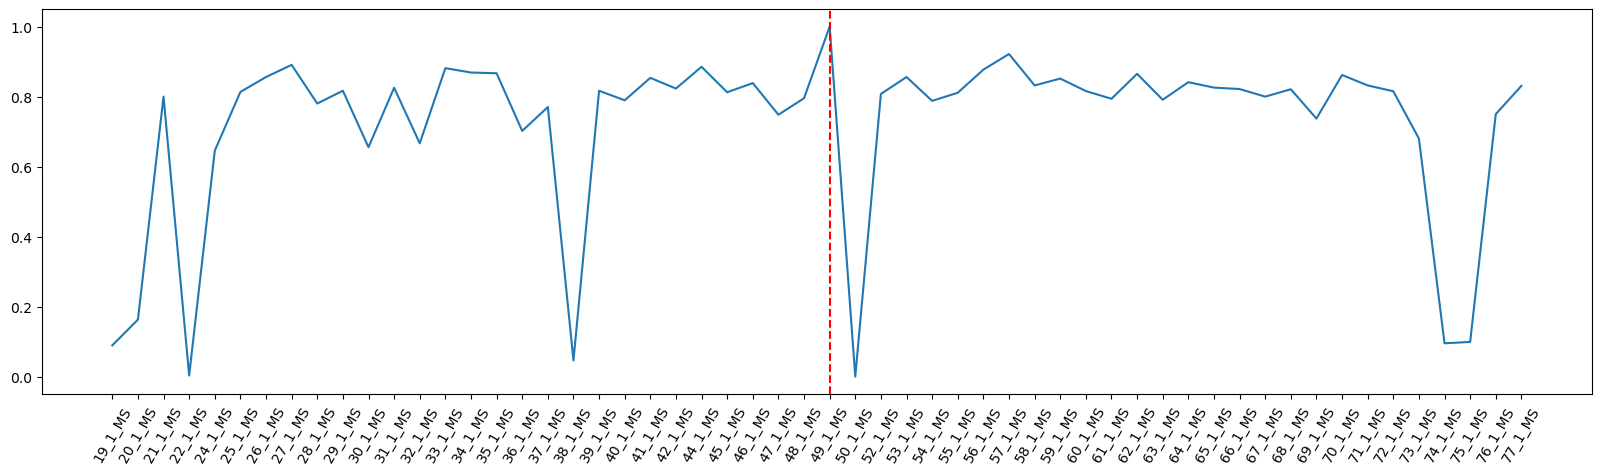

In [12]:
rep = 1
gen_ref = 49
WINDOW_LEN = 60
treatment = "MS"
label_ref = f"{gen_ref}_{rep}_{treatment}"

kk = [ f"{gen}_{rep}_{treatment}" for gen in range(gen_ref-WINDOW_LEN//2, gen_ref+WINDOW_LEN//2)]
kk = sorted(list(set(kk).intersection(ordered_matrix.index)))

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(ordered_matrix.loc[kk, f'{gen_ref}_{rep}_{treatment}'])# .sort_values(ascending=False).head(20)
ax.tick_params(axis='x', labelrotation=60)
ax.axvline(x=label_ref, color='red', linestyle='dashed')# type='---')

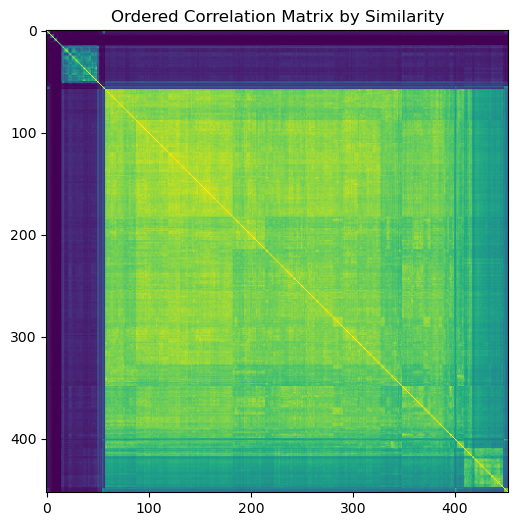

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow((np.array(ordered_matrix)))# , annot=False, cmap='coolwarm')
plt.title("Ordered Correlation Matrix by Similarity")
plt.show()

In [14]:
# for record in vcf_file.fetch():
#     print(f"Chromosome: {record.chrom}")
#     print(f"Position: {record.pos}")
#     print(f"Reference Allele: {record.ref}")
#     print(f"Alternative Alleles: {record.alts}")
#     print(f"Quality: {record.qual}")
#     print(f"Info: {dict(record.info)}")

# Analysis by frequency

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [16]:
allele_freqs = pd.DataFrame(variant_freq_dict).melt(ignore_index=False)
allele_freqs.columns = ["generation", "replica", "treatment", "freq"]
allele_freqs = allele_freqs.reset_index()
allele_freqs.generation = allele_freqs.generation.astype(int)

kk = allele_freqs[~allele_freqs.freq.isna()]
kk.apply(lambda row: (row.level_0, row.level_1), axis=1)

0               (contig000001, 227)
1              (contig000001, 5306)
3           (contig000001, 1119481)
4            (contig000002, 253240)
5            (contig000003, 382165)
                     ...           
21889934        (contig000021, 144)
21890022        (contig000029, 695)
21890023        (contig000029, 696)
21890030      (contig000016, 42680)
21890057      (contig000016, 42679)
Length: 141270, dtype: object

In [17]:
variant_count = kk.groupby('generation')[['level_0', 'level_1']].count().reset_index()
valid_generations = variant_count[variant_count['level_0'] <= 1000]['generation']
filtered_df = kk[kk['generation'].isin(valid_generations)]
filtered_df

,level_0,level_1,generation,replica,treatment,freq
0,contig000001,227,16,1,K,0.870000
1,contig000001,5306,16,1,K,1.000000
3,contig000001,1119481,16,1,K,1.000000
4,contig000002,253240,16,1,K,1.000000
5,contig000003,382165,16,1,K,0.996942
...,...,...,...,...,...,...
21889934,contig000021,144,59,3,MS,1.000000
21890022,contig000029,695,59,3,MS,1.000000
21890023,contig000029,696,59,3,MS,1.000000
21890030,contig000016,42680,59,3,MS,1.000000


In [18]:
# filtered_df.set_index(['level_0', 'level_1', 'generation']).pivot(columns=, index, values)
filtered_df = filtered_df.pivot(columns=['replica', 'treatment'], index=['level_0', 'level_1', 'generation'], values='freq').reset_index()

In [19]:
filtered_df.loc[:, ['1', '2', '3']]

replica           1             2             3     
treatment         K        MS  MS         K   K   MS
0          0.956781       NaN NaN       NaN NaN  NaN
1               NaN       NaN NaN  0.927765 NaN  NaN
2          0.958333       NaN NaN       NaN NaN  NaN
3               NaN       NaN NaN  0.982072 NaN  NaN
4               NaN       NaN NaN  0.962818 NaN  NaN
...             ...       ...  ..       ...  ..  ...
15028           NaN  1.000000 NaN       NaN NaN  NaN
15029           NaN       NaN NaN       NaN NaN  0.5
15030           NaN  0.850000 NaN       NaN NaN  NaN
15031           NaN  0.771429 NaN       NaN NaN  NaN
15032           NaN       NaN NaN       NaN NaN  1.0

[15033 rows x 6 columns]

In [20]:
# filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1)
# filtered_df.apply(lambda row: (row.level_0, row.level_1), axis=1)
data = [filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1), filtered_df.generation, filtered_df.loc[:, ['1', '2', '3']]]
data = pd.concat(data, axis=1).sort_values("generation")
data.columns = ['Variant', 'Generation'] + data.columns[2:].to_list()

/tmp/ipykernel_259047/2199248673.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = [filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1), filtered_df.generation, filtered_df.loc[:, ['1', '2', '3']]]


In [21]:
data#.groupby('Variant')['Generation'].nunique()

,Variant,Generation,"(1, K)","(1, MS)","(2, MS)","(2, K)","(3, K)","(3, MS)"
7591,"(contig000024, 13349)",0,NaN,NaN,NaN,NaN,NaN,NaN
10116,"(contig000024, 13791)",0,NaN,NaN,NaN,NaN,NaN,NaN
8023,"(contig000024, 13385)",0,NaN,NaN,NaN,NaN,NaN,NaN
11917,"(contig000024, 14060)",0,NaN,NaN,NaN,NaN,NaN,NaN
6166,"(contig000024, 13070)",0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
10042,"(contig000024, 13769)",82,1.000,1.000000,NaN,1.000000,1.000000,NaN
13637,"(contig000024, 21397)",82,NaN,1.000000,NaN,1.000000,1.000000,0.788991
10115,"(contig000024, 13784)",82,0.992,0.995074,NaN,0.997912,0.995918,NaN
2521,"(contig000004, 735653)",82,1.000,0.994286,NaN,1.000000,1.000000,NaN


In [22]:
filtered_variants = data.groupby('Variant')['Generation'].nunique()
filtered_variants = filtered_variants[filtered_variants >= 10].index  # Seleccionar las variantes válidas
filtered_data = data.set_index("Variant").loc[filtered_variants].reset_index()

In [23]:
filtered_data.groupby('Variant')[[('1', 'MS')]].std()

,"(1, MS)"
Variant,
"(contig000001, 146)",0.067684
"(contig000001, 227)",0.065831
"(contig000001, 5306)",0.060003
"(contig000001, 91539)",0.141194
"(contig000001, 91557)",0.124279
...,...
"(contig000038, 58)",0.156337
"(contig000038, 105)",0.164369
"(contig000038, 131)",NaN


In [24]:
changing_variants = filtered_data.groupby("Variant")[[('1', 'MS')]].std().iloc[:,0].sort_values(ascending=False)[:100].index
top_changing_variants_df = filtered_data.set_index("Variant").loc[changing_variants]
freq_data = top_changing_variants_df.reset_index()

In [25]:
variants_lst = [list(x) for x in top_changing_variants_df.index.unique()]
display_options = [f'{item[0]} - {item[1]}' for item in sorted(variants_lst)]
value_dict = {f'{item[0]} - {item[1]}': item for item in sorted(variants_lst)}

In [26]:
treatment_options = [('1', 'MS'), ('2', 'MS'), ('3', 'MS'), ('1', 'K'), ('2', 'K'), ('3', 'K')]
treatment_display_options = { f"{replica}_{treatment}": (replica, treatment) for replica, treatment in treatment_options }

In [27]:
@interact
def plot_freq_curves(
    variants=widgets.SelectMultiple(options=display_options, value=[display_options[0]]),
    treatments=widgets.SelectMultiple(options=treatment_display_options, value=[treatment_display_options['1_MS']])
):

    plt.figure(figsize=(15, 6))
    
    for variant in variants:
        variant = value_dict[variant]
        variant = tuple(variant)
        for treatment in treatments:        
            subset = freq_data[freq_data['Variant'] == variant]
            plt.plot(subset['Generation'].to_list(), subset[treatment].to_list(), marker='o', label=f'{treatment}')

    
    plt.title(f'Evolución de la frecuencia del alelo alternativo {"("+variants[0]+")" if len(variants)==1 else ""}')
    
    plt.xlabel('Generación')
    plt.ylabel('Frecuencia del alelo alternativo')
    plt.legend(title='Tratamiento', loc='lower right')
    plt.grid(True)
    plt.xlim(0.5)
    plt.ylim(0, 1)
    
    plt.show()


interactive(children=(SelectMultiple(description='variants', index=(0,), options=('contig000001 - 146', 'conti…